# Spotify Uploader
## a project to automatically create and update playlists on Spotify based on your listening history

## it also includes code for visualizing your listening history

# Setup

In [1]:
# Imports
!pip3 install --upgrade pip
!pip3 install pandas
!pip3 install numpy
!pip3 install spotipy
# !pip3 install pprint
!pip3 install requests
!pip install matplotlib
!pip install calplot
!pip install python-decouple
!pip install python-dotenv
# !pip install -r "requirements.txt"

In [2]:
# make sure your python path is your virtual environment.
import sys
sys.executable

'/Users/awlego/Repositories/spotify_sync/env3.10/bin/python3.10'

In [3]:
import pandas as pd
import numpy as np
import pytz 
import spotipy
import spotipy.util as util
import pprint
import requests
import matplotlib.pyplot as plt
import calplot
import calendar
import decouple

from datetime import datetime, timedelta

In [4]:
%load_ext dotenv
%dotenv

config = decouple.AutoConfig(' ')

MOST_LISTENED_TO_ID = config('MOST_LISTENED_TO_ID')
RECENT_FAVORITES_ID = config('RECENT_FAVORITES_ID')
BINGED_SONGS_ID = config('BINGED_SONGS_ID')
LASTFM_USERNAME = config('LASTFM_USERNAME')
SPOTIFY_USERNAME = config('SPOTIFY_USERNAME')

# Import Listening History and DO stuff

In [5]:
header_names = ["artist", "album", "song", "date_played"]
spotify_history = pd.read_csv(f"{LASTFM_USERNAME}.csv", header=None, names=header_names)

spotify_history['date_played'] = pd.to_datetime(spotify_history['date_played'], utc=True, infer_datetime_format=True)
spotify_history['date_played'] = spotify_history['date_played'].dt.tz_convert('US/Pacific')
spotify_history = spotify_history.dropna()

### Let's take a look at our dataframe to make sure we can see our history. If the history is long, you should see your newest 5 and oldest 5 listens.

In [6]:
spotify_history

,artist,album,song,date_played
1,Taylor Swift,Midnights (3am Edition),you're On Your OWn KId,2022-10-28 10:38:00-07:00
2,Taylor Swift,Midnights (3am Edition),sNOw on the beach (feat. lana del rey),2022-10-28 10:34:00-07:00
3,Taylor Swift,Midnights (3am Edition),Anti-Hero,2022-10-28 10:30:00-07:00
4,Taylor Swift,Midnights (3am Edition),Maroon,2022-10-28 10:27:00-07:00
5,Taylor Swift,Midnights (3am Edition),lAveNDER hAZe,2022-10-28 10:23:00-07:00
...,...,...,...,...
45881,A Tribe Called Quest,The Love Movement,Find a Way,2019-03-19 18:40:00-07:00
45882,A Tribe Called Quest,Midnight Marauders,Award Tour,2019-03-19 18:36:00-07:00
45883,A Tribe Called Quest,The Anthology,Electric Relaxation,2019-03-19 18:33:00-07:00
45884,A Tribe Called Quest,People's Instinctive Travels and the Paths of ...,Can I Kick It?,2019-03-19 18:28:00-07:00


### calculate a bunch of interesting stuff

In [7]:
def calc_play_counts(history):
    play_counts_df =  history.groupby(["artist", "album", "song"]).size().rename('play_count').reset_index().sort_values('play_count', ascending=False)
    return play_counts_df

calc_play_counts(spotify_history)

,artist,album,song,play_count
8483,Penny and Sparrow,Finch,Don't Wanna Be Without Ya,164
10751,Taylor Swift,folklore,exile (feat. Bon Iver),123
8478,Penny and Sparrow,Don't Wanna Be Without Ya,Don't Wanna Be Without Ya,114
1362,Bon Iver,22 A Million,8 (circle),95
10833,Tessa Violet,Bad Ideas,Crush,93
...,...,...,...,...
3156,Ellie Goulding,Hate Me (with Juice WRLD),Hate Me (with Juice WRLD),1
3157,Ellie Goulding,Lights,Lights - Single Version,1
7617,Muse,The Resistance,United States of Eurasia (+Collateral Damage),1
3158,Ellie Goulding,Power,Power,1


In [8]:
def get_most_played_artists(spotify_history):
    play_counts_df = calc_play_counts(spotify_history)
    return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)

get_most_played_artists(spotify_history)[0:30]

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_74156/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)


,play_count
artist,
Bon Iver,1369
Taylor Swift,1342
Penny and Sparrow,1224
The Oh Hellos,1128
Ed Sheeran,1054
dodie,885
Jon Bellion,859
Zac Brown Band,590
Mat Kearney,580


In [9]:
def calc_most_listened_all_time(history, limit=50):
    counts = calc_play_counts(history)
    return counts.iloc[0:limit]
    

calc_most_listened_all_time(spotify_history)[0:10]

,artist,album,song,play_count
8483,Penny and Sparrow,Finch,Don't Wanna Be Without Ya,164
10751,Taylor Swift,folklore,exile (feat. Bon Iver),123
8478,Penny and Sparrow,Don't Wanna Be Without Ya,Don't Wanna Be Without Ya,114
1362,Bon Iver,22 A Million,8 (circle),95
10833,Tessa Violet,Bad Ideas,Crush,93
1414,Bon Iver,U (Man Like),U (Man Like),92
2989,Ed Sheeran,No.6 Collaborations Project,South of the Border (feat. Camila Cabello & Ca...,92
11477,The Oh Hellos,The Oh Hellos EP,Hello My Old Heart,92
12960,dodie,Human,monster,91
2988,Ed Sheeran,No.6 Collaborations Project,Remember the Name (feat. Eminem & 50 Cent),87


In [10]:
def calc_recent_favorites(history, limit=50, time_frame_days=30):
    time_frame = datetime.now(pytz.timezone('US/Pacific')) - timedelta(days=time_frame_days)
    history = history.loc[history['date_played'] > time_frame]
    counts = calc_play_counts(history)
    return counts.iloc[0:limit]
    
calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)

,artist,album,song,play_count
82,Charlie Puth,Charlie Be Quiet!,cHarLiE bE qUiEt!,37
475,Yama,Haru wo Tsugeru,Haru wo Tsugeru,27
484,Yama,the meaning of life,血流,19
332,Peter Gabriel,Wall-E (Original Motion Picture Soundtrack),Down to Earth,18
137,Ed Sheeran,Celestial,cElEstIAl,17
408,TWICE,Formula of Love: O+T=<3,The Feels,17
237,Lil Nas X,STAR WALKIN' (League of Legends Worlds Anthem),STAR WALKIN' (League of Legends Worlds Anthem),16
14,Ao,Change,Change,15
23,Ao,ripple,ripple,15
18,Ao,Look,already,15


# Make & Update Some Playlists!

## Spotify API Setup

In [11]:
scope = 'playlist-modify-private'
username = SPOTIFY_USERNAME
token = util.prompt_for_user_token(username, scope)

### Define the playlist creation/modification code

In [12]:
def make_playlist(username, token, playlist_name, playlist_description):
    if token:
        sp = spotipy.Spotify(auth=token)
        sp.trace = False
        playlists = sp.user_playlist_create(username, playlist_name,
                                            playlist_description)
    else:
        print("Can't get token for", username)
    return playlists


def playlist_replace_tracks(username, token, playlist_id, tracks):
    if token:
        sp = spotipy.Spotify(auth=token)
        sp.trace = True
        playlists = sp.user_playlist_replace_tracks(username, playlist_id, tracks)
    else:
        print("Can't get token for", username)
    return playlists


def lookup_track(artist, album, song, token):
    sp = spotipy.Spotify(auth=token)
    probable_song_name = song
    search_result = sp.search(f'{probable_song_name} {artist} {album}')
    try:
        result = search_result['tracks']['items'][0]['id']
    except (KeyError, IndexError):
        result = None
        pass
    return result

    
def make_recent_favorites(username, token):
    recent_favs = calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)
    recent_favs['spotify_id'] = recent_favs.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    
    track_ids = recent_favs['spotify_id']
    if token:
        playlist_results = make_playlist(username, token, "Recent Favorites", False)
        print(playlist_results)
        sp = spotipy.Spotify(auth=token)
        sp.user_playlist_add_tracks(username, playlist_results['id'], track_ids)
    else:
        print("Can't get token for", username)
        
        
def update_recent_favorites(username, token, playlist_id):
    recent_favs = calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)
    # apparently some songs fail if they have really long titles
    recent_favs['spotify_id'] = recent_favs.apply(lambda x: lookup_track(x['artist'][0:15], x['album'][0:15], x['song'][0:15], token), axis=1)
    track_ids = recent_favs['spotify_id']
    track_ids = track_ids.dropna()

    playlist_results = playlist_replace_tracks(username, token, playlist_id, track_ids)

# I keep this code around to debug errors that I sometimes get.
# every once in a while a song comes up that breaks the way I'm doing things and I need
# to fix it.
# lookup_track("Daft Punk", "Random Access Memories", "Instant Crush feat. Julian Casablancas", token)
# scope = 'playlist-modify-private'
# username = SPOTIFY_USERNAME
# token = util.prompt_for_user_token(username, scope)
# make_playlist(username, token, "my_api_playlist", False)
# make_recent_favorites(username, token)
# update_recent_favorites(username, token, RECENT_FAVORITES_ID)

# recent_favs = calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)
# recent_favs

In [13]:
def calc_binged_songs(spotify_history):
    spotify_history['day_played'] = spotify_history['date_played'].dt.date
    df =  spotify_history.groupby(["artist", "album", "song", "day_played"]).size().rename('daily_play_count').reset_index().sort_values('daily_play_count', ascending=False)
    df = df.where(df['daily_play_count'] >= 3).dropna()
    df = df.groupby(['artist', 'album', 'song'])['daily_play_count'].sum().rename('summed_top_daily_play_counts').reset_index().sort_values('summed_top_daily_play_counts', ascending=False)
    return df[0:25]

def update_binged_songs(username, token):
    binged_songs = calc_binged_songs(spotify_history)
    binged_songs['spotify_id'] = binged_songs.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    track_ids = binged_songs['spotify_id']
    track_ids = track_ids.dropna()
    playlist_results = playlist_replace_tracks(username, token, BINGED_SONGS_ID, track_ids)
    
print(calc_binged_songs(spotify_history))
# update_binged_songs(username, token)

                  artist                           album  \
37               Carbine                     sauce it up   
207    Penny and Sparrow       Don't Wanna Be Without Ya   
319            Yung Lean                           Starz   
27              Bon Iver                    U (Man Like)   
7             Aphex Twin                   Come to Daddy   
39          Charlie Puth               Charlie Be Quiet!   
325       Zac Brown Band                         Uncaged   
272         Taylor Swift                        folklore   
216    Penny and Sparrow                          Gogogo   
327       Zac Brown Band                         Uncaged   
266              TV Girl                     French Exit   
212    Penny and Sparrow                           Finch   
121              Jhameel                           Waves   
290         The Mowgli's            Waiting for the Dawn   
271         Taylor Swift                        folklore   
170          Mat Kearney                

In [14]:
def update_most_listened_all_time(username, token, playlist_id):
    most_listened_df = calc_most_listened_all_time(spotify_history)
    most_listened_df['spotify_id'] = most_listened_df.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    track_ids = most_listened_df['spotify_id']
    track_ids = track_ids.dropna()
    playlist_results = playlist_replace_tracks(username, token, playlist_id, track_ids)
    
# update_most_listened_all_time(username, token, MOST_LISTENED_TO_ID)

In [15]:
def update_playlist(username, token, playlist_id, calc_func):
    df = calc_func(spotify_history)
    df['spotify_id'] = df.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    track_ids = df['spotify_id']
    track_ids = track_ids.dropna()
    playlist_results = playlist_replace_tracks(username, token, playlist_id, track_ids)

## Create the playlists
This only needs to be run once. Uncomment to create the playlists. You will need to take the IDs here and add them to your .env file

In [16]:
# # make my most listened to playlist and print it so I can get the ID
# print(make_playlist(username, token, "Most Listened To", False))
# print(make_playlist(username, token, "Binged Songs", False))
# idk why I made this one different but I did
# make_recent_favorites()

## Actually update the playlists!

In [17]:
def update_all_playlists(username, token):
#     for key in AUTOGENERATED_PLAYLISTS:
#         update_playlist(username, token, playlist[AUTOGENERATED_PLAYLISTS[key]])
    update_most_listened_all_time(username, token, MOST_LISTENED_TO_ID)
    update_recent_favorites(username, token, RECENT_FAVORITES_ID)
    update_binged_songs(username, token)

update_all_playlists(username, token)

# Visualizations / Data

/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:193: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas a

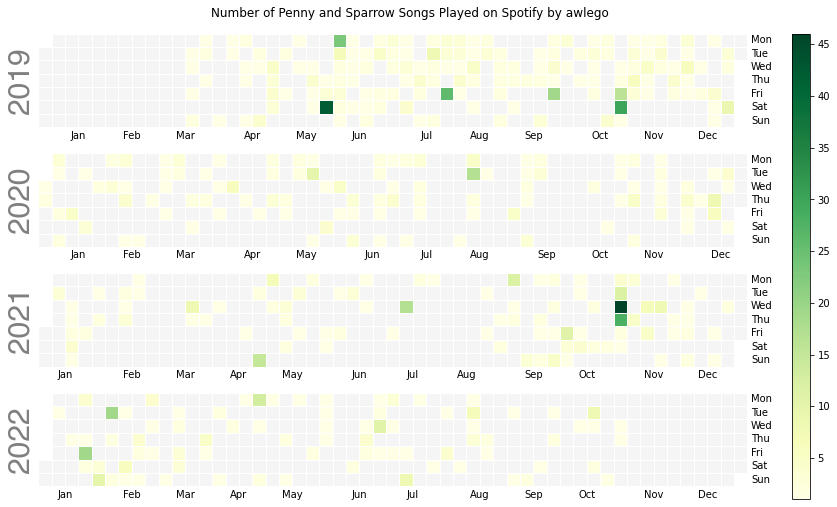

In [19]:
def calc_play_times(history):
    df = history
    df['day_of_week_played_en'] = df['date_played'].apply(lambda x: calendar.day_name[x.weekday()])
    df['day_of_week_played_num'] = df['date_played'].apply(lambda x: x.weekday())
    
    df = df.groupby(['day_of_week_played_num', 'day_of_week_played_en']).count()
    df = df.rename(columns={'day_played': 'play_count'})
    df = df.filter(['play_count'], axis='columns')    
    df.plot.bar(title="Awlego's Spotify Playcount by Day of Week")
    
def calc_cal_heatmap(spotify_history, artist_filter=None):
    spotify_history['day_played_datetime'] = spotify_history['date_played'].dt.date
    if artist_filter:
        spotify_history = spotify_history.where(spotify_history['artist'] == artist_filter).dropna()
    df = spotify_history.groupby('day_played').count()
    
    df = spotify_history.set_index(['date_played'])
    df['number'] = 1
    

    if artist_filter:
        title = f'Number of {artist_filter} Songs Played on Spotify by awlego'
    else:
        title = 'Number of Songs Played on Spotify by awlego'

    ax = calplot.calplot(df['number'], cmap='YlGn', dropzero=True, edgecolor=None, colorbar=True, suptitle=title)
# calc_play_times(spotify_history)
# calc_cal_heatmap(spotify_history)
calc_cal_heatmap(spotify_history, artist_filter='Penny and Sparrow')

In [20]:
def most_consistently_listened_to_artists(spotify_history):
    df = spotify_history.groupby(['artist', 'day_played_datetime'])['day_played_datetime'].count().reset_index(name="num_artist_play_days")
    df = df.sort_values('num_artist_play_days', ascending=False)
    print(df[0:10])

most_consistently_listened_to_artists(spotify_history)

               artist day_played_datetime  num_artist_play_days
13521     Mat Kearney          2019-09-18                    73
9826      Jon Bellion          2019-04-11                    60
22139   The Oh Hellos          2019-08-01                    55
20324    Taylor Swift          2019-05-06                    55
24758  Zac Brown Band          2021-11-03                    54
5926       Ed Sheeran          2021-10-30                    54
9499        Jim Yosef          2022-09-01                    54
12886         MAMAMOO          2022-07-27                    53
22163   The Oh Hellos          2019-10-07                    52
4269         Coldplay          2021-10-20                    52


# Stop
this should throw an error so you can hit "run all cells" without worrying about the playground going wild

In [ ]:
stop

# Playground
below here I promise nothing

In [ ]:
#todo
# combine the multiple versions of songs together and pick the one that I have saved and if not saved then the one that I have more playcounts for.


In [ ]:
def find_standout_songs(spotify_history, timewindow):
    df = calc_play_counts(spotify_history)
    
# find_standout_songs(spotify_history)

In [ ]:
# def update_recently_played(username, token, playlist_id):
    
def recently_played():
    """Calculates the last 50 songs played."""
    pass

In [ ]:
def save_all_liked_songs():
    """save a list of all the songs I've added to my library so if I ever lose it
    I could rebuild my library"""
    sp = spotipy.Spotify()

    scope = 'user-library-read'

    username = SPOTIFY_USERNAME

    token = util.prompt_for_user_token(username, scope)

    if token:
        sp = spotipy.Spotify(auth=token)
        results = sp.current_user_saved_tracks()
        for item in results['items']:
            track = item['track']
            print(track['name'] + ' - ' + track['artists'][0]['name'])
    else:
        print("Can't get token for", username)
    

## testing directly getting my lastfm data

In [ ]:
requests.get('https://api.github.com')

In [ ]:
data = {
    'method':'user.getrecenttracks',
    'user':username,
    'api_key':'e8db1a5e26f01ca1abae47d64738e9b4',
    'limit':200,
    'page': 1,
}

response = requests.post("https://ws.audioscrobbler.com/2.0/", data=data)
# json_response = response.json()

In [ ]:
response.status_code

In [ ]:
import xml.etree.ElementTree as ET
import json

!pip3 install xmljson
from xmljson import badgerfish as bf

In [ ]:
tree = ET.fromstring(response.text)
tree

In [ ]:
temp = json.dumps(bf.data(tree))
df = pd.read_json(temp)

In [ ]:
df

In [ ]:
temp

In [ ]:
scope = 'user-read-recently-played'
token = util.prompt_for_user_token(username, scope)
header = {
   "access_token": token,
   'Authorization': 'Bearer {0}'.format(token),
}
data = {
    'limit': 50
}

# note: songs have to finish for this to catch them.
response = requests.get('https://api.spotify.com/v1/me/player/recently-played',
                        headers=header,
                        params=data)

In [ ]:
print(response.status_code)
for item in response.json()['items']:
    print(item['track']['name'])
#     print(item['track'])

In [ ]:
twenty_twenty_history = spotify_history.where(spotify_history['date_played'].dt.year == 2020).dropna()

In [ ]:
twenty_twenty_history

In [ ]:
calc_most_listened_all_time(twenty_twenty_history)

In [ ]:
get_most_played_artists(twenty_twenty_history)[0:10]

In [ ]:
get_most_played_artists(spotify_history)[0:10]

In [ ]:
history_2021 = spotify_history.where(spotify_history['date_played'].dt.year == 2021).dropna()

In [ ]:
calc_most_listened_all_time(history_2021)

In [ ]:
get_most_played_artists(history_2021)[0:10]